In [ ]:
# Importing essential libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing specific modules from libraries
from torchvision import transforms
from os import path
from scipy.ndimage import rotate
from torch import nn
from sklearn.metrics import confusion_matrix

# Importing utility modules
import random
from torch.utils.data import Dataset, DataLoader, sampler
from copy import deepcopy
import nibabel as nib

In [ ]:
!wget --show-progress --verbose --tries=3 --no-check-certificate https://aramislab.paris.inria.fr/files/data/databases/DL4MI/OASIS-1-dataset_pt_new.tar.gz

--2024-06-01 18:13:29--  https://aramislab.paris.inria.fr/files/data/databases/DL4MI/OASIS-1-dataset_pt_new.tar.gz
Resolving aramislab.paris.inria.fr (aramislab.paris.inria.fr)... 128.93.101.235
Connecting to aramislab.paris.inria.fr (aramislab.paris.inria.fr)|128.93.101.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1387416064 (1.3G) [application/octet-stream]
Saving to: ‘OASIS-1-dataset_pt_new.tar.gz’

OASIS-1-dataset_pt_ 100%[===================>]   1.29G  13.4MB/s    in 87s     

2024-06-01 18:14:57 (15.2 MB/s) - ‘OASIS-1-dataset_pt_new.tar.gz’ saved [1387416064/1387416064]



In [ ]:
! tar xf OASIS-1-dataset_pt_new.tar.gz -C ./

   participant_id session_id alternative_id_1 sex  education_level  age_bl  \
0  sub-OASIS10001    ses-M00    OAS1_0001_MR1   F              2.0      74   
1  sub-OASIS10002    ses-M00    OAS1_0002_MR1   F              4.0      55   
2  sub-OASIS10003    ses-M00    OAS1_0003_MR1   F              4.0      73   
3  sub-OASIS10004    ses-M00    OAS1_0004_MR1   M              NaN      28   
4  sub-OASIS10005    ses-M00    OAS1_0005_MR1   M              NaN      18   

  diagnosis_bl laterality   MMS  cdr_global diagnosis  
0           CN          R  29.0         0.0        CN  
1           CN          R  29.0         0.0        CN  
2           AD          R  27.0         0.5        AD  
3           CN          R  30.0         NaN        CN  
4           CN          R  30.0         NaN        CN  


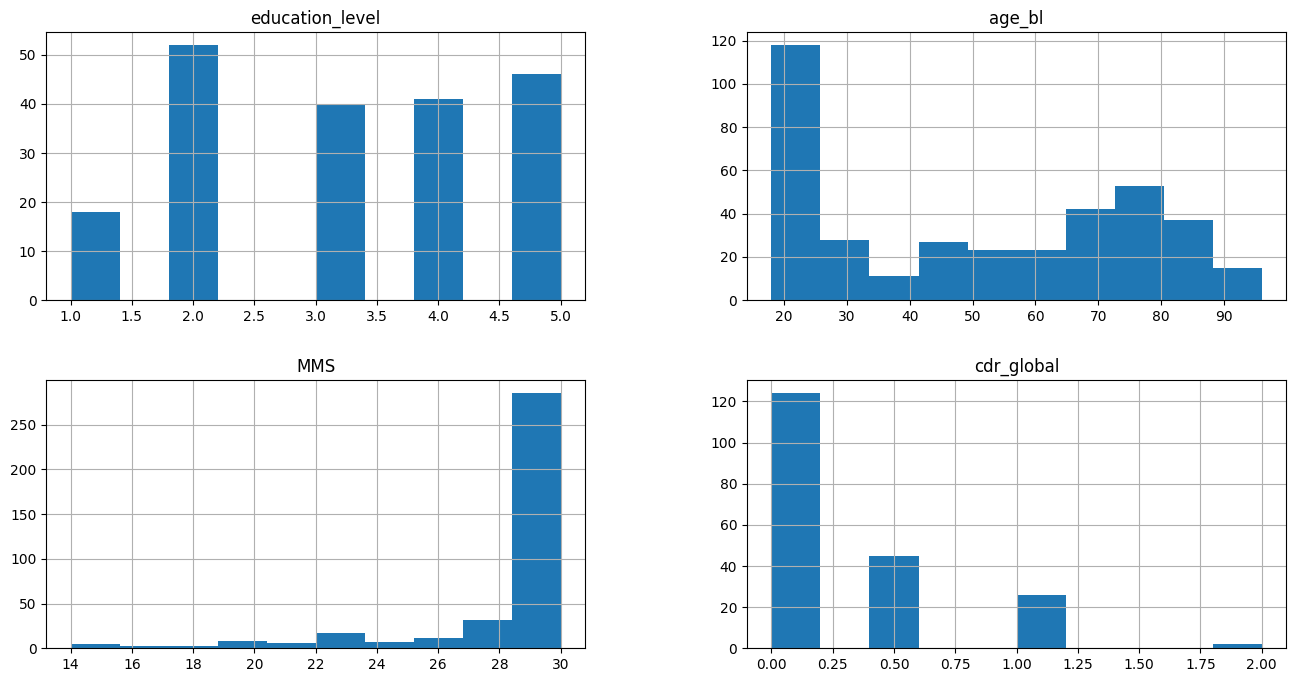

In [ ]:
# File path
file_path = 'OASIS-1_dataset/tsv_files/lab_1/OASIS_BIDS.tsv'

# Columns to load
columns_to_load = [
    'participant_id', 'session_id', 'alternative_id_1', 'sex',
    'education_level', 'age_bl', 'diagnosis_bl', 'laterality', 'MMS',
    'cdr_global', 'diagnosis']

# Read the CSV file using pandas of dataset
df_data = pd.read_csv(file_path, sep='\t', usecols=columns_to_load)
# Show first five items of the table
print(df_data.head())
# First visual inspection
_ = df_data.hist(figsize=(16, 8))

In [ ]:
class ds_MRI(Dataset):

    def __init__(self, image_directory, df_dataset, list_transforms=None):

        self.image_directory = image_directory
        self.list_transforms = list_transforms
        self.df_dataset = df_dataset
        self.diagnostic_code = {"AD": 1, "CN": 0}
        # Set the size attribute based on the shape of the first image in the dataset
        if len(self.df_dataset) > 0:
            self.size = self.__getitem__(0)['image'].shape
        else:
            raise ValueError("The dataset is empty, cannot determine image shape.")

    def __len__(self):
        return len(self.df_dataset)

    def __getitem__(self, idx):

        diag_stage = self.df_dataset.loc[idx, 'diagnosis']
        diagnosis_label = self.diagnostic_code[diag_stage]

        patient_id = self.df_dataset.loc[idx, 'participant_id']
        assignment_id = self.df_dataset.loc[idx, 'session_id']
        patient_file = (
            f'subjects/{patient_id}/{assignment_id}/'
            f'deeplearning_prepare_data/image_based/custom/'
            f'{patient_id}_{assignment_id}_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability.pt'
        )

        patient_image = torch.load(path.join(self.image_directory, patient_file))

        if self.list_transforms:
            patient_image = self.list_transforms(patient_image)

        sample = {'image': patient_image, 'label': diagnosis_label,
                  'participant_id': patient_id,
                  'session_id': assignment_id}
        return sample

    def train(self):
        self.list_transforms.train()

    def eval(self):
        self.list_transforms.eval()

In [ ]:

class CropRightHippoCampus(object):
    """Crops the right hippocampus of a MRI"""

    def __init__(self, rndm_move=0):
        self.rndm_move = rndm_move
        self.training_mode = True

    def __call__(self, img):
        if self.training_mode:
            x_dir = random.randint(-self.rndm_move, self.rndm_move)
            y_dir = random.randint(-self.rndm_move, self.rndm_move)
            z_dir = random.randint(-self.rndm_move, self.rndm_move)
        else:
            x_dir, y_dir, z_dir = 0, 0, 0

        # Calculate the indices for cropping
        x_start, x_end = 65 + x_dir, 95 + x_dir
        y_start, y_end = 50 + y_dir, 90 + y_dir
        z_start, z_end = 27 + z_dir, 57 + z_dir

        # Perform the crop and clone the resulting tensor
        return img[:, x_start:x_end, y_start:y_end, z_start:z_end].clone()

    def train(self):
        self.training_mode = True

    def eval(self):
        self.training_mode = False

In [ ]:
ds_train = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/train.tsv', sep='\t')
ds_test = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/validation.tsv', sep='\t')

class PadMaxPool3d(nn.Module):

    def __init__(self, kernel_size, stride, return_indices=False, return_pad=False):
            super().__init__()
            self.kernel_size = kernel_size
            self.stride = stride
            self.return_indices = return_indices
            self.return_pad = return_pad

            # Initialize the pooling and padding layers
            self.pool = nn.MaxPool3d(kernel_size=kernel_size, stride=stride, return_indices=return_indices)
            self.pad = nn.ConstantPad3d(padding=0, value=0)

    def forward(self, temp_map):
        coords = []
        for i in range(3):
            size = temp_map.size(i + 2)
            remainder = size % self.stride
            adjustment = self.stride - remainder
            coords.append(adjustment)

        coords = [0 if coord == self.stride else coord for coord in coords]

        self.pad.padding = (coords[2], 0, coords[1], 0, coords[0], 0)

        if self.return_indices:
            output, indices = self.pool(self.pad(temp_map))

            if self.return_pad:
                padding_info = (coords[2], 0, coords[1], 0, coords[0], 0)
                return output, indices, padding_info
            else:
                return output, indices

        else:
            output = self.pool(self.pad(temp_map))

            if self.return_pad:
                padding_info = (coords[2], 0, coords[1], 0, coords[0], 0)
                return output, padding_info
            else:
                return output

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        current_channels = in_channels
        for i in range(num_layers):
            layer = nn.Sequential(
                nn.BatchNorm3d(current_channels),
                nn.ReLU(inplace=True),
                nn.Conv3d(current_channels, growth_rate, kernel_size=3, padding=1, bias=False),
                nn.Dropout3d(0.2)
            )
            self.layers.append(layer)
            current_channels += growth_rate

    def forward(self, x):
        for layer in self.layers:
            new_features = layer(x)
            x = torch.cat([x, new_features], 1)
        return x

class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.downsample = nn.Sequential(
            nn.BatchNorm3d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.AvgPool3d(2, stride=2)
        )

    def forward(self, x):
        return self.downsample(x)

class DenseNet3D(nn.Module):
    def __init__(self):
        super(DenseNet3D, self).__init__()
        growth_rate = 16
        num_blocks = [6, 12, 48, 32]  # Example configuration of layers in each block
        num_init_features = 16
        compression_factor = 0.5

        self.initial_conv = nn.Conv3d(1, num_init_features, kernel_size=3, padding=1)

        # Dense blocks and transition layers
        num_features = num_init_features
        self.blocks = nn.ModuleList()
        for i, num_layers in enumerate(num_blocks):
            block = DenseBlock(num_layers, num_features, growth_rate)
            self.blocks.append(block)
            num_features += num_layers * growth_rate

            if i != len(num_blocks) - 1:
                out_features = int(num_features * compression_factor)
                transition = TransitionLayer(num_features, out_features)
                self.blocks.append(transition)
                num_features = out_features

        # Final batch normalization and classifier
        self.final_bn = nn.BatchNorm3d(num_features)
        self.global_pool = nn.AdaptiveAvgPool3d(1)
        self.classifier = nn.Linear(num_features, 2)

    def forward(self, x):
        x = self.initial_conv(x)
        for block in self.blocks:
            x = block(x)
        x = F.relu(self.final_bn(x))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [ ]:
import torch.nn as nn

def train(model, train_loader, val_loader, criterion, optimizer, n_epochs):

    best_model = deepcopy(model)
    train_best_loss = np.inf
    losses = {'train': [], 'val': []}

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        count = 0

        for data in train_loader:
            images, labels = data['image'].cuda(), data['label'].cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            count += 1

        train_loss = total_loss / count
        losses['train'].append(train_loss)

        # Validation loss
        model.eval()
        total_val_loss = 0
        val_count = 0
        with torch.no_grad():
            for data in val_loader:
                images, labels = data['image'].cuda(), data['label'].cuda()
                outputs = model(images)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
                val_count += 1

        val_loss = total_val_loss / val_count
        losses['val'].append(val_loss)

        print(f"Epoch {epoch}: Train loss = {train_loss:.4f}, Val loss = {val_loss:.4f}")

        if val_loss < train_best_loss:
            best_model = deepcopy(model)
            train_best_loss = val_loss

    return best_model, losses

def plot_losses_per_lr(losses_dict):
    """
    Plots training and validation losses for each learning rate in separate graphs.

    Args:
        losses_dict: Dictionary where key is the learning rate and value is another dict
                     containing 'train' and 'val' losses lists.
    """
    for lr, losses in losses_dict.items():
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(losses['train'], label='Training Loss', color='blue')
        plt.title(f'Training Loss (LR={lr})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(losses['val'], label='Validation Loss', color='red')
        plt.title(f'Validation Loss (LR={lr})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

def test(model, data_loader, criterion):

    model.eval()
    data_loader.dataset.eval()
    columns = ["participant_id", "proba0", "proba1", "true_label", "predicted_label"]
    final_df = pd.DataFrame(columns=columns)
    total_loss = 0

    # Disable gradient computation for validation/testing
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            # Move images and labels to GPU
            images = data['image'].cuda()
            labels = data['label'].cuda()
            # Forward pass: compute predicted outputs
            outputs = model(images)
            # Compute the loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            # Compute probabilities using Softmax
            probs = nn.Softmax(dim=1)(outputs)
            # Get the predicted class with the highest probability
            _, predicted = torch.max(outputs.data, 1)
            # Prepare data for the results DataFrame
            rows = [
                [
                    data['participant_id'][idx],
                    probs[idx, 0].item(),
                    probs[idx, 1].item(),
                    labels[idx].item(),
                    predicted[idx].item()
                ]
                for idx in range(len(data['participant_id']))
            ]

            # Create a DataFrame from the rows and concatenate to the results DataFrame
            batch_df = pd.DataFrame(rows, columns=columns)
            final_df = pd.concat([final_df, batch_df], ignore_index=True)

    # Convert the true_labels and predicted_labels to integers

    true_labels = final_df['true_label'].to_numpy(dtype=int)
    predicted_labels = final_df['predicted_label'].to_numpy(dtype=int)

    # Print unique values and types for debugging
    print("True labels unique values:", np.unique(true_labels), "Type:", true_labels.dtype)
    print("Predicted labels unique values:", np.unique(predicted_labels), "Type:", predicted_labels.dtype)

    # Compute metrics for true and predicted labels
    final_metrics = compute_metrics(true_labels, predicted_labels)

    # Reset the index of the results DataFrame
    final_df.reset_index(drop=True, inplace=True)

    # Calculate mean loss and add it to the results metrics
    mean_loss = total_loss / len(data_loader.dataset)
    final_metrics['mean_loss'] = mean_loss

    return final_df, final_metrics

def compute_metrics(ground_truth, prediction):
    """Computes the accuracy, sensitivity, specificity, balanced accuracy, and confusion matrix"""
    # Ensure that ground_truth and prediction are numpy arrays
    ground_truth = np.array(ground_truth)
    prediction = np.array(prediction)

    # Compute confusion matrix
    cm = confusion_matrix(ground_truth, prediction)

    true_positives = np.sum((prediction == 1) & (ground_truth == 1))
    true_negatives = np.sum((prediction == 0) & (ground_truth == 0))
    false_positives = np.sum((prediction == 1) & (ground_truth == 0))
    false_negatives = np.sum((prediction == 0) & (ground_truth == 1))

    metrics_dict = dict()
    metrics_dict['accuracy'] = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

    # Sensitivity
    if true_positives + false_negatives != 0:
        metrics_dict['sensitivity'] = true_positives / (true_positives + false_negatives)
    else:
        metrics_dict['sensitivity'] = 0.0

    # Specificity
    if false_positives + true_negatives != 0:
        metrics_dict['specificity'] = true_negatives / (false_positives + true_negatives)
    else:
        metrics_dict['specificity'] = 0.0

    metrics_dict['balanced_accuracy'] = (metrics_dict['sensitivity'] + metrics_dict['specificity']) / 2
    metrics_dict['confusion_matrix'] = cm

    # Print the confusion matrix
    print("Confusion Matrix:\n", cm)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return metrics_dict

def plot_separate_losses(loss_history):
    """
    Function to plot training and validation losses on separate graphs for the best performing model.

    Args:
        loss_history: (dict) containing lists of training and validation losses
    """
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss_history['train'], label='Training Loss', color='blue')
    plt.title('Training Loss for Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(loss_history['val'], label='Validation Loss', color='red')
    plt.title('Validation Loss for Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def display_confusion_matrix(conf_matrix):
    """
    Displays the confusion matrix using seaborn heatmap.

    Args:
        conf_matrix: (numpy array) the confusion matrix
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Best Model')
    plt.show()



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 2.3531, Val loss = 9.9003
Epoch 1: Train loss = 2.0749, Val loss = 11.8083
Epoch 2: Train loss = 1.6941, Val loss = 8.2910
Epoch 3: Train loss = 1.6344, Val loss = 8.9507
Epoch 4: Train loss = 1.3057, Val loss = 9.4632
Epoch 5: Train loss = 1.6032, Val loss = 9.4189
Epoch 6: Train loss = 1.3824, Val loss = 9.6920
Epoch 7: Train loss = 1.3511, Val loss = 13.4955
Epoch 8: Train loss = 1.4706, Val loss = 8.5711
Epoch 9: Train loss = 1.5619, Val loss = 7.7951
Epoch 10: Train loss = 1.2853, Val loss = 8.0996
Epoch 11: Train loss = 1.4446, Val loss = 8.1661
Epoch 12: Train loss = 1.4693, Val loss = 8.3667
Epoch 13: Train loss = 1.2122, Val loss = 8.3084
Epoch 14: Train loss = 1.3923, Val loss = 11.5310


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[58  4]
 [ 5 10]]


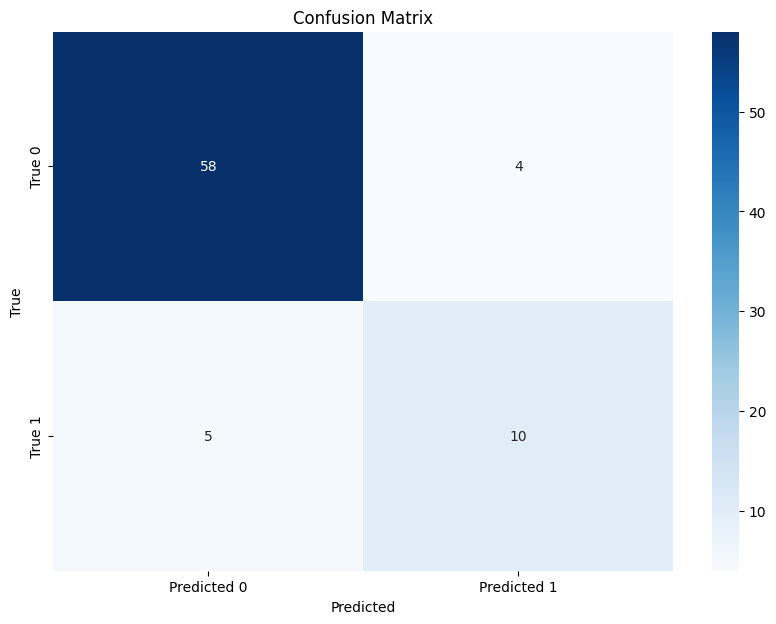

Learning Rate: 0.001 - Validation Accuracy: 0.8831168831168831


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 2.1642, Val loss = 9.5530
Epoch 1: Train loss = 1.8633, Val loss = 10.4947
Epoch 2: Train loss = 1.7555, Val loss = 8.4963
Epoch 3: Train loss = 1.6270, Val loss = 14.9083
Epoch 4: Train loss = 1.4498, Val loss = 8.2775
Epoch 5: Train loss = 1.4604, Val loss = 8.5630
Epoch 6: Train loss = 1.5658, Val loss = 8.2168
Epoch 7: Train loss = 1.4450, Val loss = 7.5880
Epoch 8: Train loss = 1.3716, Val loss = 7.8939
Epoch 9: Train loss = 1.4618, Val loss = 7.9625
Epoch 10: Train loss = 1.2877, Val loss = 9.2781
Epoch 11: Train loss = 1.2913, Val loss = 8.4779
Epoch 12: Train loss = 1.2705, Val loss = 8.1036
Epoch 13: Train loss = 1.2240, Val loss = 7.5456
Epoch 14: Train loss = 1.2449, Val loss = 7.3366


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[59  3]
 [ 6  9]]


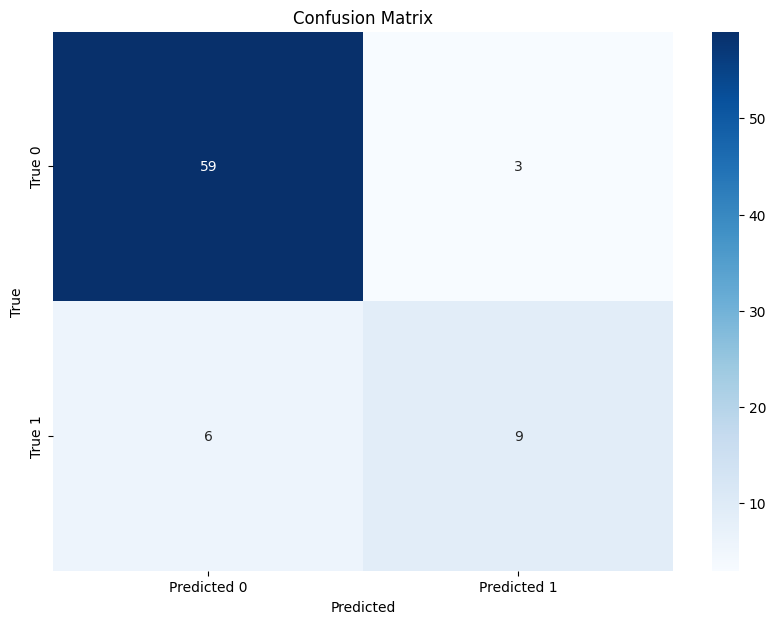

Learning Rate: 0.0005 - Validation Accuracy: 0.8831168831168831


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 2.0273, Val loss = 9.5691
Epoch 1: Train loss = 1.8808, Val loss = 9.1140
Epoch 2: Train loss = 1.6986, Val loss = 9.9347
Epoch 3: Train loss = 1.7717, Val loss = 9.4781
Epoch 4: Train loss = 1.6068, Val loss = 8.9711
Epoch 5: Train loss = 1.4043, Val loss = 11.1599
Epoch 6: Train loss = 1.6662, Val loss = 8.7194
Epoch 7: Train loss = 1.4361, Val loss = 7.5565
Epoch 8: Train loss = 1.3203, Val loss = 8.2455
Epoch 9: Train loss = 1.3833, Val loss = 7.5945
Epoch 10: Train loss = 1.3003, Val loss = 9.7297
Epoch 11: Train loss = 1.2371, Val loss = 9.2768
Epoch 12: Train loss = 1.2882, Val loss = 7.3984
Epoch 13: Train loss = 1.2223, Val loss = 9.9874
Epoch 14: Train loss = 1.2635, Val loss = 7.5215


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[55  7]
 [ 4 11]]


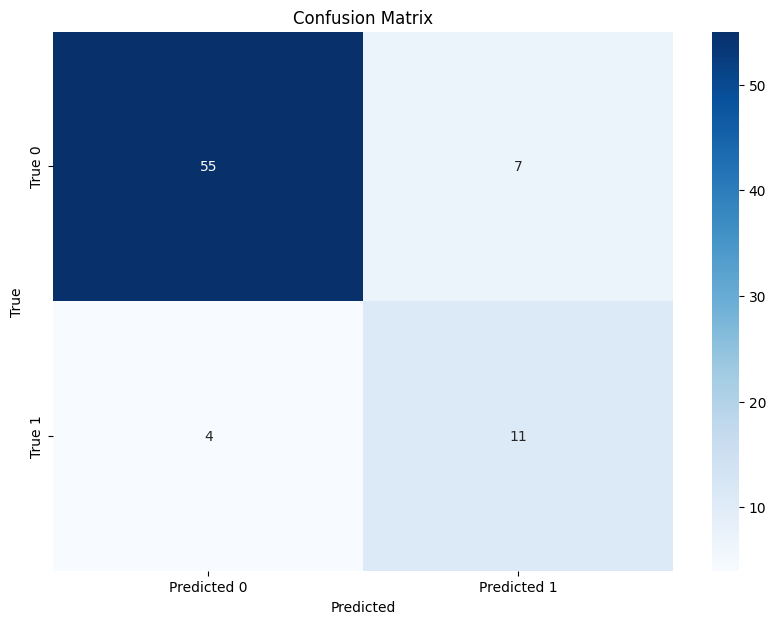

Learning Rate: 0.0001 - Validation Accuracy: 0.8571428571428571


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 2.1862, Val loss = 10.8907
Epoch 1: Train loss = 1.9078, Val loss = 8.6617
Epoch 2: Train loss = 1.7007, Val loss = 10.5441
Epoch 3: Train loss = 1.6342, Val loss = 9.7647
Epoch 4: Train loss = 1.5646, Val loss = 7.7885
Epoch 5: Train loss = 1.5146, Val loss = 16.0480
Epoch 6: Train loss = 1.5077, Val loss = 8.0457
Epoch 7: Train loss = 1.5615, Val loss = 7.4917
Epoch 8: Train loss = 1.4054, Val loss = 8.6499
Epoch 9: Train loss = 1.3241, Val loss = 9.0302
Epoch 10: Train loss = 1.3760, Val loss = 7.7061
Epoch 11: Train loss = 1.4257, Val loss = 7.4106
Epoch 12: Train loss = 1.3052, Val loss = 7.5004
Epoch 13: Train loss = 1.1777, Val loss = 8.6969
Epoch 14: Train loss = 1.1900, Val loss = 8.0490


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[58  4]
 [ 6  9]]


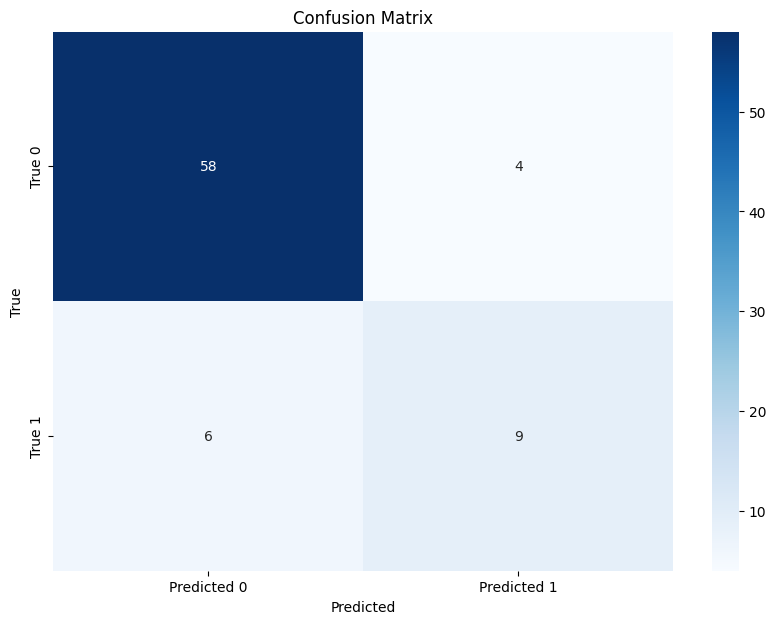

Learning Rate: 5e-05 - Validation Accuracy: 0.8701298701298701


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 2.6815, Val loss = 19.7118
Epoch 1: Train loss = 2.2352, Val loss = 16.0869
Epoch 2: Train loss = 2.0197, Val loss = 17.4429
Epoch 3: Train loss = 1.9954, Val loss = 11.9819
Epoch 4: Train loss = 1.8670, Val loss = 12.2127
Epoch 5: Train loss = 1.7606, Val loss = 10.5151
Epoch 6: Train loss = 1.6885, Val loss = 12.6511
Epoch 7: Train loss = 1.6954, Val loss = 11.6569
Epoch 8: Train loss = 1.7088, Val loss = 9.4192
Epoch 9: Train loss = 1.6481, Val loss = 9.6016
Epoch 10: Train loss = 1.6151, Val loss = 9.1711
Epoch 11: Train loss = 1.4756, Val loss = 8.3245
Epoch 12: Train loss = 1.3961, Val loss = 9.7458
Epoch 13: Train loss = 1.5628, Val loss = 11.7680
Epoch 14: Train loss = 1.4737, Val loss = 14.0483


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[55  7]
 [ 4 11]]


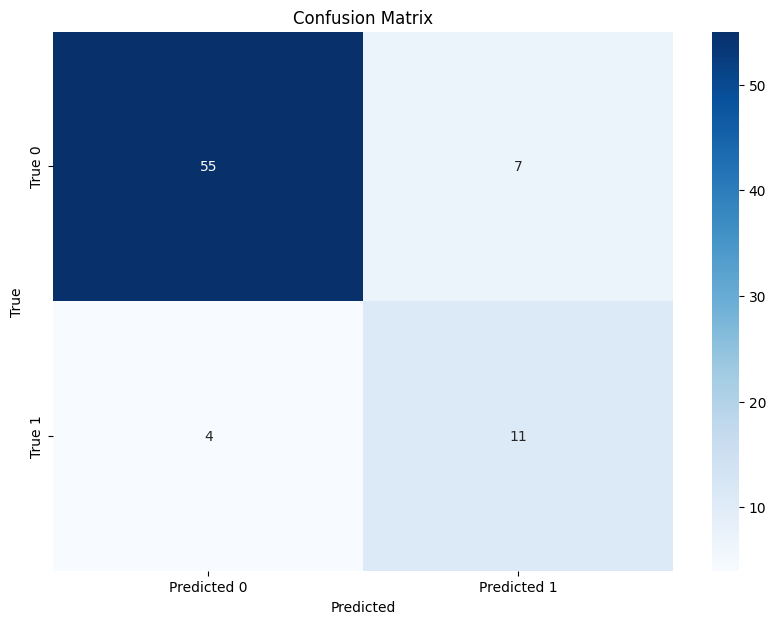

Learning Rate: 1e-05 - Validation Accuracy: 0.8571428571428571


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 2.2505, Val loss = 16.5553
Epoch 1: Train loss = 2.2422, Val loss = 15.8311
Epoch 2: Train loss = 2.1799, Val loss = 16.4879
Epoch 3: Train loss = 2.1799, Val loss = 16.9407
Epoch 4: Train loss = 2.1044, Val loss = 17.0557
Epoch 5: Train loss = 2.1238, Val loss = 16.9845
Epoch 6: Train loss = 2.0227, Val loss = 17.1559
Epoch 7: Train loss = 2.0606, Val loss = 18.3088
Epoch 8: Train loss = 1.9740, Val loss = 17.1452
Epoch 9: Train loss = 1.9572, Val loss = 18.0244
Epoch 10: Train loss = 1.9880, Val loss = 17.6606
Epoch 11: Train loss = 1.9702, Val loss = 15.8569
Epoch 12: Train loss = 1.9185, Val loss = 17.1688
Epoch 13: Train loss = 1.9028, Val loss = 16.1289
Epoch 14: Train loss = 1.9465, Val loss = 16.7624


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0] Type: int64
Confusion Matrix:
 [[62  0]
 [15  0]]


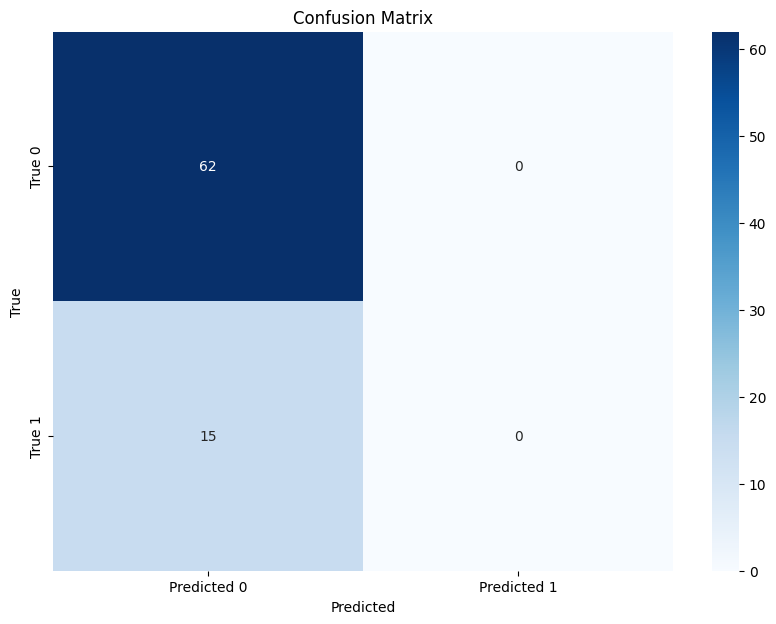

Learning Rate: 1e-06 - Validation Accuracy: 0.8051948051948052


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 2.2477, Val loss = 17.1279
Epoch 1: Train loss = 2.1048, Val loss = 18.6008
Epoch 2: Train loss = 2.0106, Val loss = 16.0515
Epoch 3: Train loss = 2.0377, Val loss = 17.2526
Epoch 4: Train loss = 1.9079, Val loss = 15.0808
Epoch 5: Train loss = 1.7903, Val loss = 16.3517
Epoch 6: Train loss = 1.7655, Val loss = 12.5228
Epoch 7: Train loss = 1.6523, Val loss = 17.0013
Epoch 8: Train loss = 1.6620, Val loss = 13.9053
Epoch 9: Train loss = 1.6842, Val loss = 12.7524
Epoch 10: Train loss = 1.4879, Val loss = 19.1717
Epoch 11: Train loss = 1.6953, Val loss = 12.2785
Epoch 12: Train loss = 1.5144, Val loss = 9.3158
Epoch 13: Train loss = 1.6136, Val loss = 12.0535
Epoch 14: Train loss = 1.5778, Val loss = 9.4009


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[51 11]
 [ 4 11]]


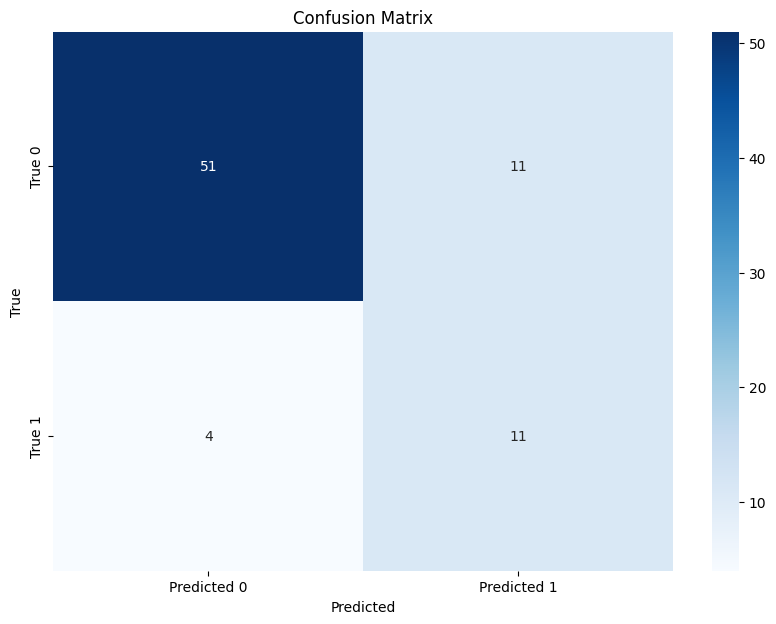

Learning Rate: 5e-06 - Validation Accuracy: 0.8051948051948052


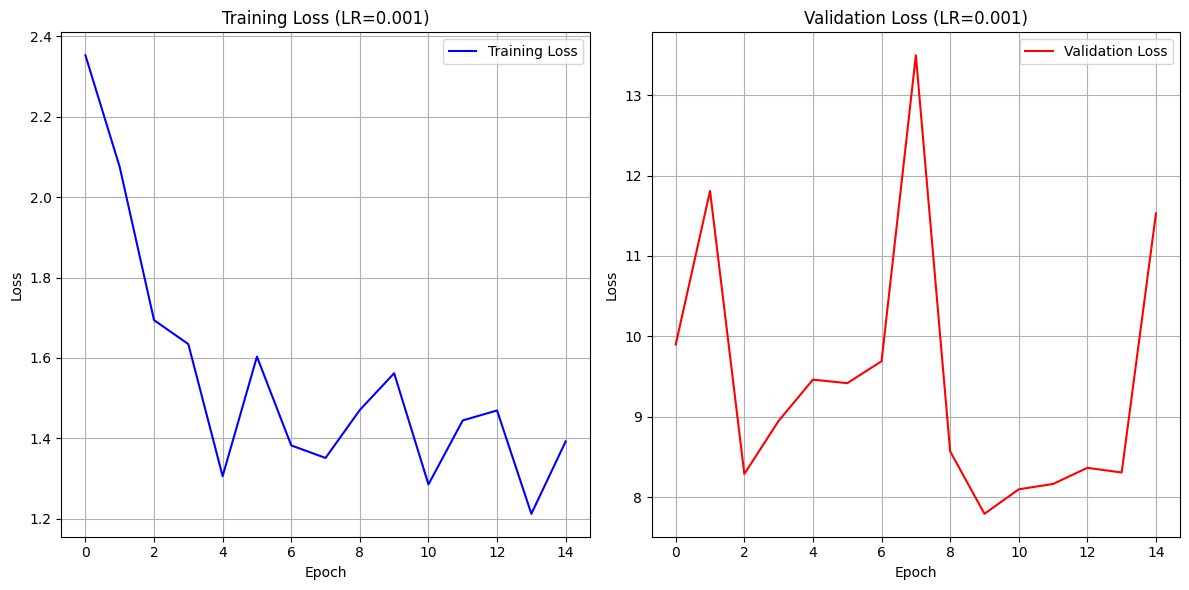

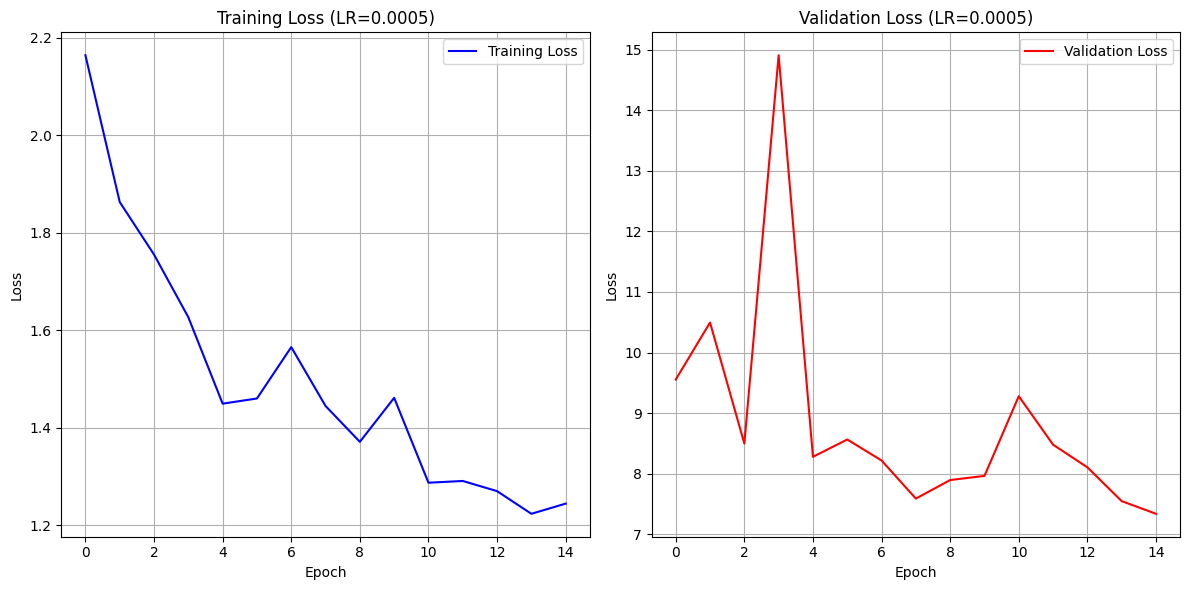

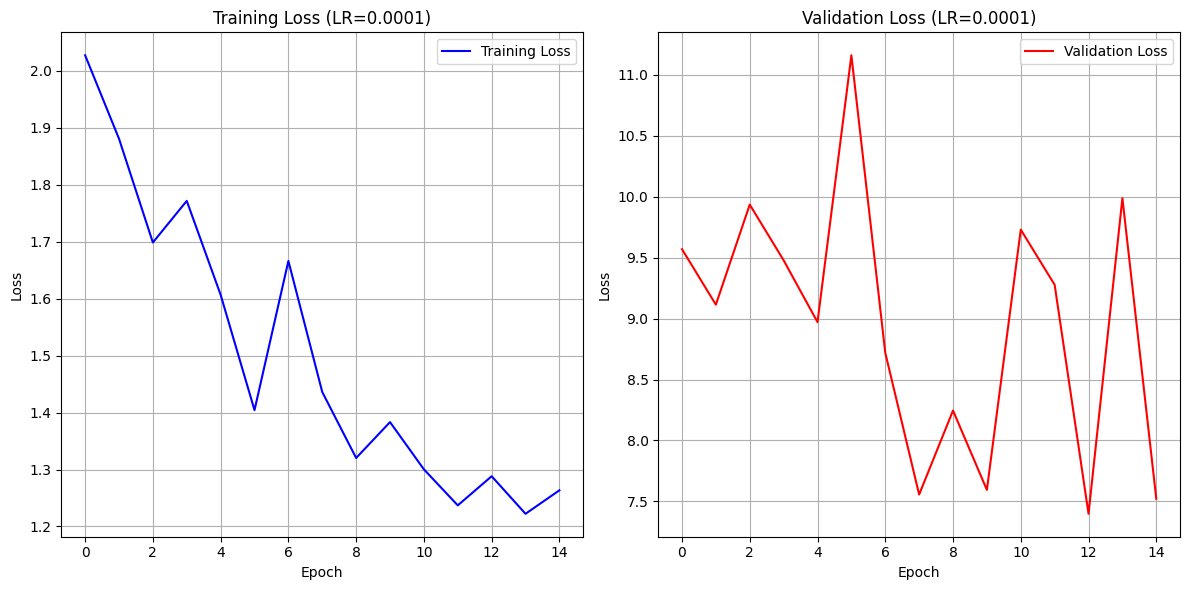

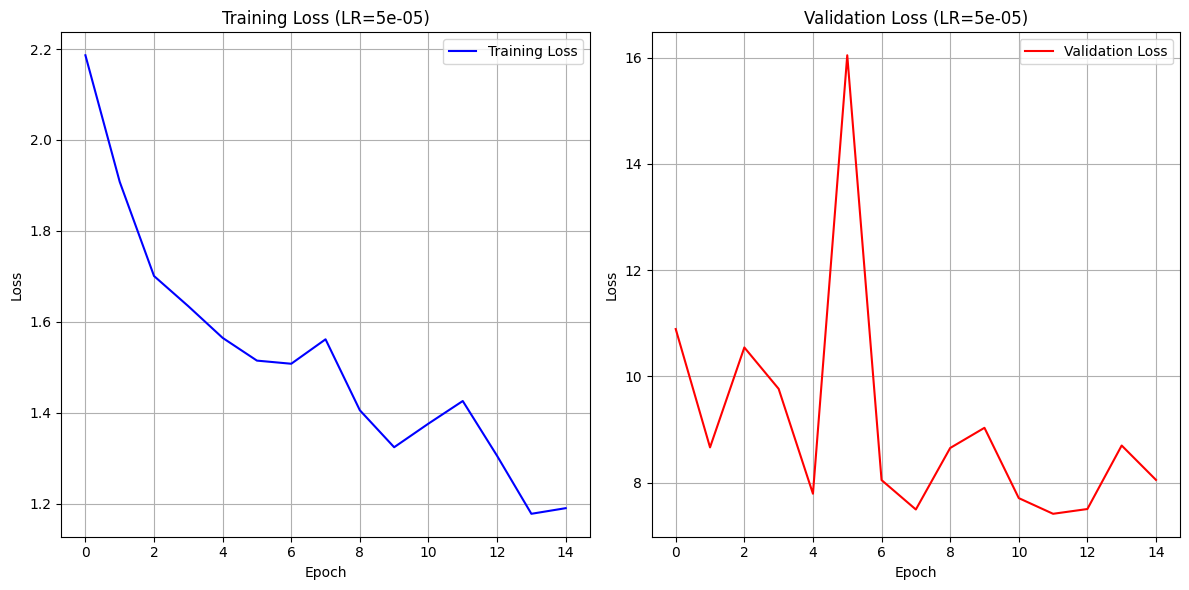

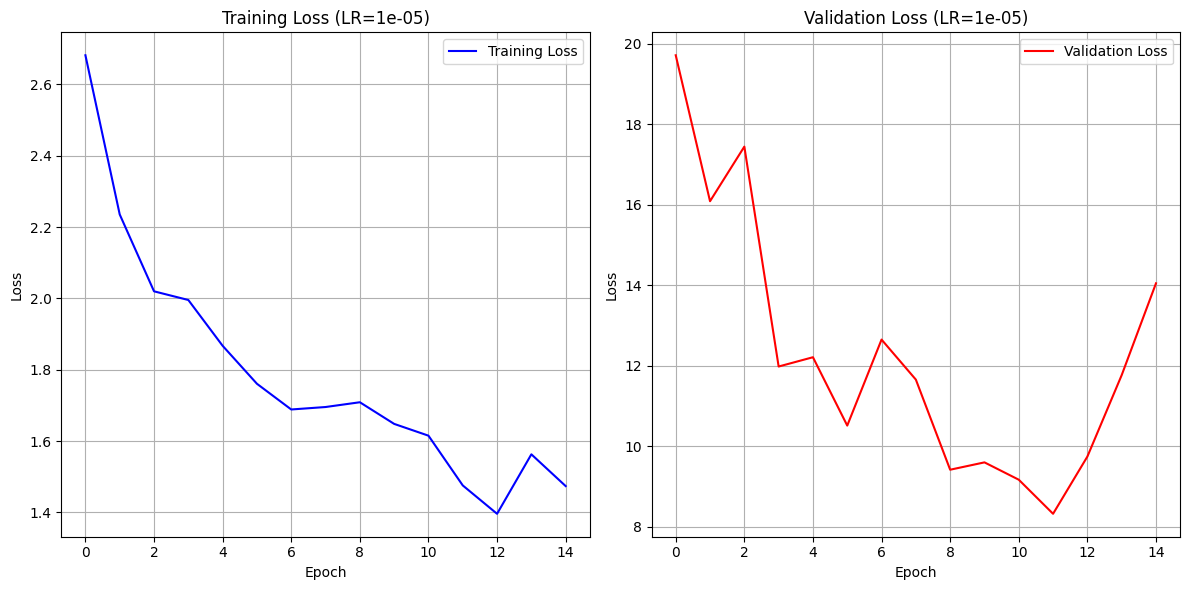

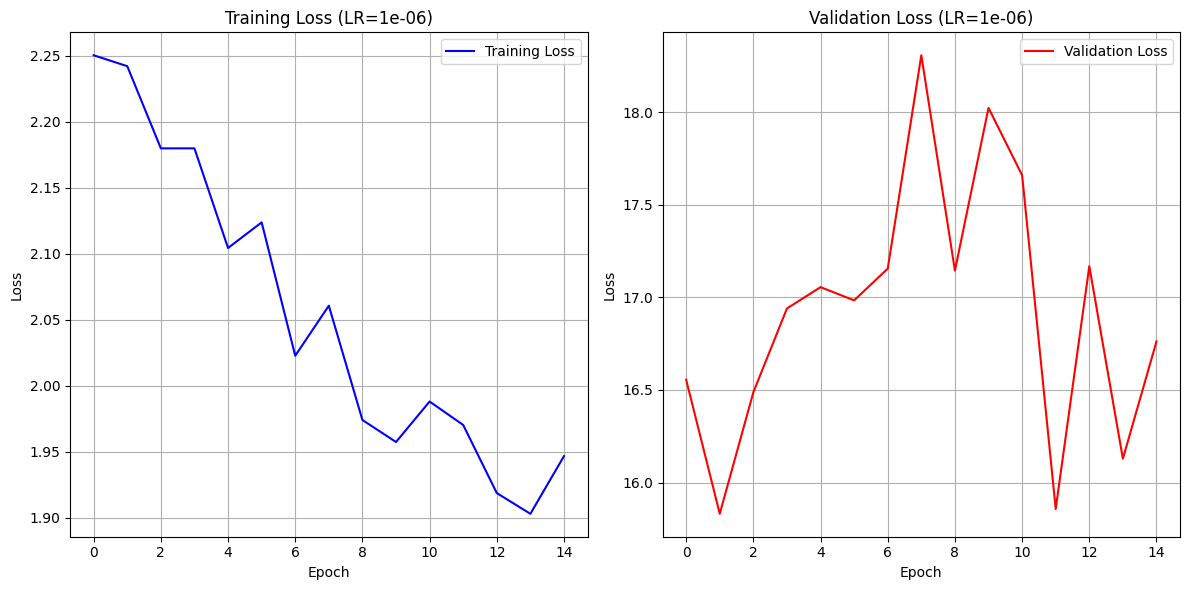

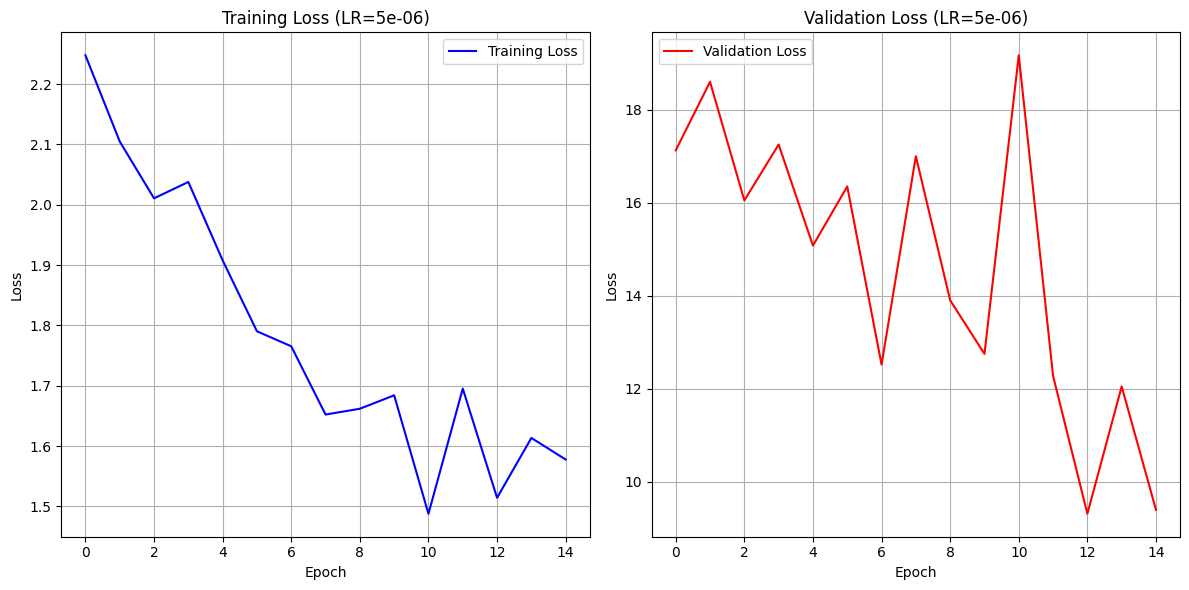

In [ ]:
import itertools
# Path setup, dataset, and transforms

image_directory = path.join('OASIS-1_dataset', 'CAPS')
list_transforms = CropRightHippoCampus(2)

train_RightHippoCampus = ds_MRI(image_directory, ds_train, list_transforms=list_transforms)
test_RightHippoCampus = ds_MRI(image_directory, ds_test, list_transforms=list_transforms)

# Hyperparameter setup
learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 1e-6, 5e-6]
n_epochs = 15
batch_size = 4
loss_histories = {}

# Training and validation setup
for lr in learning_rates:
    model_RightHippoCampus = DenseNet3D().cuda()
    optimizer = torch.optim.Adam(model_RightHippoCampus.parameters(), lr=lr)
    trainloader_RightHC = DataLoader(train_RightHippoCampus, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    testloader_RightHC = DataLoader(test_RightHippoCampus, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

    # Train and evaluate the model
    best_model, losses = train(model_RightHippoCampus, trainloader_RightHC, testloader_RightHC, nn.CrossEntropyLoss(reduction='sum').cuda(), optimizer, n_epochs)
    loss_histories[lr] = losses

    # Evaluate the model
    valid_resultsLeftHC_df, valid_metricsLeftHC  = test(best_model, testloader_RightHC, nn.CrossEntropyLoss(reduction='sum').cuda())
    print(f"Learning Rate: {lr} - Validation Accuracy: {valid_metricsLeftHC['accuracy']}")

# Plot losses for each learning rate
plot_losses_per_lr(loss_histories)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 2.3475, Val loss = 16.4416
Epoch 1: Train loss = 2.0741, Val loss = 14.5405
Epoch 2: Train loss = 1.9621, Val loss = 13.4971
Epoch 3: Train loss = 1.9186, Val loss = 14.3350
Epoch 4: Train loss = 1.8350, Val loss = 11.5538
Epoch 5: Train loss = 1.7527, Val loss = 8.1870
Epoch 6: Train loss = 1.6388, Val loss = 8.6680
Epoch 7: Train loss = 1.7082, Val loss = 10.4940
Epoch 8: Train loss = 1.5274, Val loss = 10.7359
Epoch 9: Train loss = 1.5945, Val loss = 9.3089


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[60  2]
 [ 7  8]]


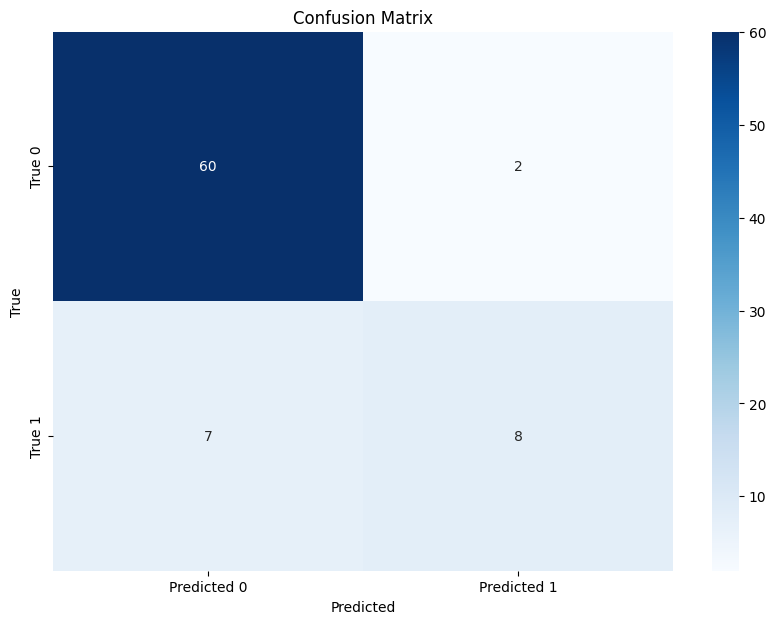

Learning Rate: 1e-05 - Validation Accuracy: 0.8831168831168831


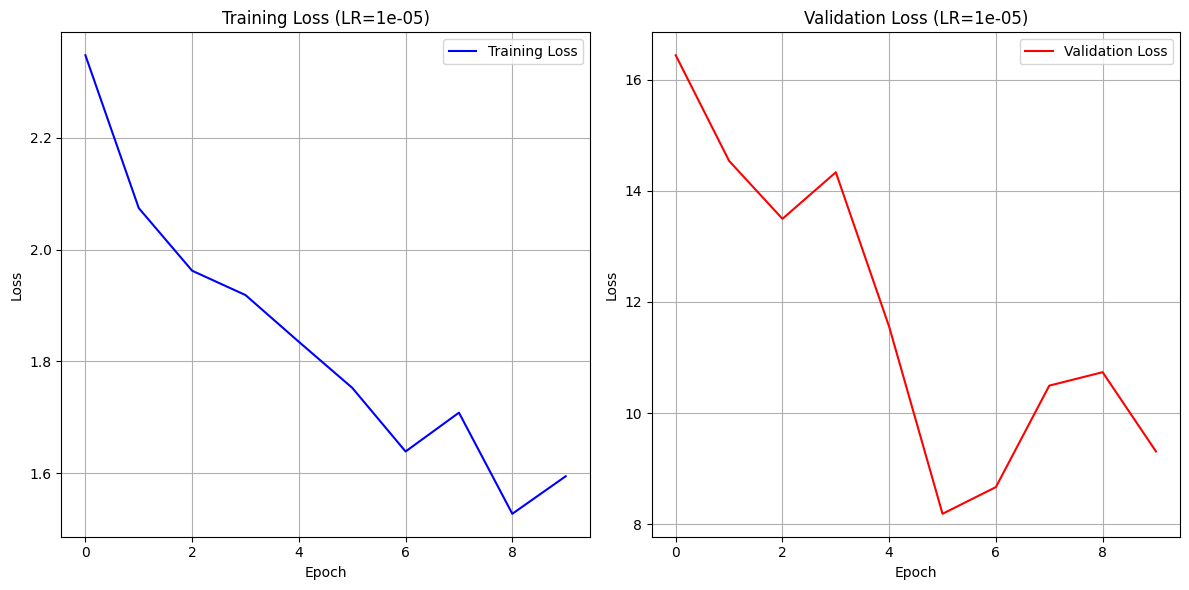

In [ ]:
import itertools
# Path setup, dataset, and transforms

image_directory = path.join('OASIS-1_dataset', 'CAPS')
list_transforms = CropRightHippoCampus(2)

train_RightHippoCampus = ds_MRI(image_directory, ds_train, list_transforms=list_transforms)
test_RightHippoCampus = ds_MRI(image_directory, ds_test, list_transforms=list_transforms)

# Hyperparameter setup
learning_rates = [1e-5]
n_epochs = 10
batch_size = 4
loss_histories = {}

# Training and validation setup
for lr in learning_rates:
    model_RightHippoCampus = DenseNet3D().cuda()
    optimizer = torch.optim.Adam(model_RightHippoCampus.parameters(), lr=lr)
    trainloader_RightHC = DataLoader(train_RightHippoCampus, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    testloader_RightHC = DataLoader(test_RightHippoCampus, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

    # Train and evaluate the model
    best_model, losses = train(model_RightHippoCampus, trainloader_RightHC, testloader_RightHC, nn.CrossEntropyLoss(reduction='sum').cuda(), optimizer, n_epochs)
    loss_histories[lr] = losses

    # Evaluate the model
    valid_resultsLeftHC_df, valid_metricsLeftHC  = test(best_model, testloader_RightHC, nn.CrossEntropyLoss(reduction='sum').cuda())
    print(f"Learning Rate: {lr} - Validation Accuracy: {valid_metricsLeftHC['accuracy']}")

# Plot losses for each learning rate
plot_losses_per_lr(loss_histories)